## RQ1: What is the accuracy of individual learners in predicting security vulnerabilities?
## Deliverables
1. Confusion matrix for each learner x 4 (1 for each learner) = 4 CMs.
2. Performance metrics (Accuracy, Precision and Recall) for each learner x 4 learners = 4 rows of metrics.
3. AUC-ROC curve for all learners x 1 combined graph = 1 AUC-ROC graph.

## Learners
1. Decision Tree Classifier
2. Logistic Regression
3. Naive Bayes Classifier
4. XGBoost Classifier

## Datasets
1. Apache Tomcat
2. Apache Struts2-core

### Prerequisites

In [ ]:
# Basic imports
import numpy as np
import pandas as pd
import sys

# Data preprocessing
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

# Feature selection
from sklearn.feature_selection import SequentialFeatureSelector as SFS
from sklearn.feature_selection import RFE

# Handling imbalance data
from imblearn.over_sampling  import RandomOverSampler

# CV
from sklearn.model_selection import RepeatedStratifiedKFold

# Performance metrics
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from sklearn.model_selection import cross_val_score
from matplotlib import pyplot as plt
from numpy import mean
from sklearn.metrics import ConfusionMatrixDisplay as CMD
from sklearn.metrics import roc_curve

#ML models
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from xgboost import XGBClassifier

def preprocess(dataset_idx, target, version=None):
    ds = ["./datasets/tomcat-final.csv", "./datasets/struts-final.csv"]
    df = pd.read_csv(ds[dataset_idx])
    np.set_printoptions(threshold=np.inf)
    pd.set_option('max_columns', None)
    print(f"Dataframe {ds[dataset_idx][-16:]} created..\nTotal number of rows: ", df.shape[0])
    df = cleanup(df)
    return split_features_variables(df, target, version)

def cleanup(df):
    df.loc[df['title'].str.contains('Denial', case=False), 'title'] = 'DoS'
    df.loc[df['title'].str.contains('CSRF', case=False), 'title'] = 'CSRF'
    df.loc[df['title'].str.contains(
        'information disclosure', case=False), 'title'] = 'Information Disclosure'
    df.loc[df['title'].str.contains(
        'cve-2020-9484', case=False), 'title'] = 'Remote Code execution'
    df.loc[df['title'].str.contains(
        'session hijacking', case=False), 'title'] = 'Remote Code execution'
    df = df.drop_duplicates(keep='first').reset_index(drop=True)
    return df

def split_features_variables(df, target, version):
    y_cols = ['vulnerable', 'severity', 'title']
    feature_columns = df.columns[2:-4]
    if version:
        train = df.loc[~(df.version == version)]
        test = df.loc[df.version == version]
    else:
        train, test = train_test_split(df, shuffle=True,test_size=0.3)
    X = train[feature_columns]
    test_X = test[feature_columns]
    if y_cols[target] == 'vulnerable':
        y = train[y_cols[target]]
        test_Y = test[y_cols[target]]
    else: 
        label_X_train, label_X_test = label_encode(train, test)
        y = label_X_train[y_cols[target]]
        test_Y = label_X_test[y_cols[target]]
    return X, test_X, y, test_Y  


def label_encode(train, test):
    print('Labelled target found..')
    s = (train.dtypes == 'object')
    object_cols = ['severity', 'title']
    label_X_train = train.copy()
    label_X_test = test.copy()
    le = LabelEncoder()
    label_X_train[object_cols] = train[object_cols].apply(le.fit_transform)
    label_X_test[object_cols] = test[object_cols].apply(le.fit_transform)
    print('Encoded...')
    return label_X_train, label_X_test

def fit_feature_set(feature_set):
    global X_ros
    X_ros = X_ros[feature_set]
    global test_X
    test_X = test_X[feature_set]
  
def predict(model):
    model.fit(X_ros, y_ros)
    predictions = model.predict(test_X)
    kfold=RepeatedStratifiedKFold(n_splits=10,n_repeats=3,random_state=1)
    accuracy = accuracy_score(test_Y, predictions)
    precision = precision_score(test_Y, predictions, average='weighted')
    recall = recall_score(test_Y, predictions,average='weighted')
    return [accuracy, precision, recall, predictions]

### Experiments


In [ ]:
X, test_X, y, test_Y = preprocess(1, 2)
ros = RandomOverSampler()
X_ros, y_ros = ros.fit_resample(X, y)

Dataframe struts-final.csv created..
Total number of rows:  19372
Labelled target found..
Encoded...


### Feature selection

In [ ]:
sfs = SFS(DecisionTreeClassifier(), 
          direction='forward',
          scoring='r2',
          cv=5)
sfs.fit(X_ros,y_ros)
sfs_features = []
for i in range(X.shape[1]):
    if(sfs.support_[i] == 1):
        sfs_features.append(X.columns[i])

rfe = RFE(estimator=DecisionTreeClassifier())
rfe.fit(X_ros, y_ros)
rfe_features = []
for i in range(X.shape[1]):
    if(rfe.support_[i] == 1):
        rfe_features.append(X.columns[i])

### Machine Learning

Change feature set here


In [ ]:
fit_feature_set(rfe_features)

#### Decision Tree

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Accuracy: 0.6175559380378658
Precision: 0.9976719187216818
Recall: 0.6175559380378658


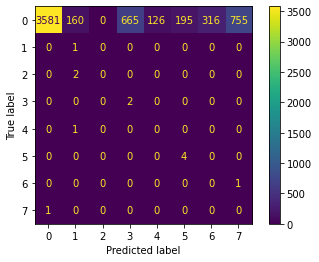

In [ ]:
dt = DecisionTreeClassifier(ccp_alpha=0.036)
dt_pred_arr = predict(dt)
dt_pred = dt_pred_arr[-1]
print(f'Accuracy: {mean(dt_pred_arr[0])}')
print(f'Precision: {mean(dt_pred_arr[1])}')
print(f'Recall: {mean(dt_pred_arr[2])}')
CMD.from_estimator(dt, test_X, test_Y)

#### Logistic Regression

Accuracy: 0.612564543889845
Precision: 0.997380909163684
Recall: 0.6125645438898452


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,


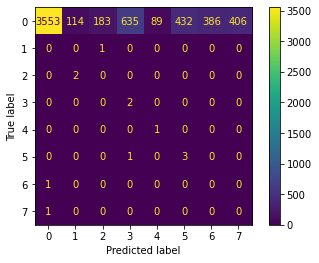

In [ ]:
lr = LogisticRegression(solver='saga', class_weight='balanced')
lr_pred_arr = predict(lr)
lr_pred = lr_pred_arr[-1]
print(f'Accuracy: {mean(lr_pred_arr[0])}')
print(f'Precision: {mean(lr_pred_arr[1])}')
print(f'Recall: {mean(lr_pred_arr[2])}')
CMD.from_estimator(lr, test_X, test_Y)

#### Gaussian NB

Accuracy: 0.4368330464716007
Precision: 0.9975849156139023
Recall: 0.4368330464716007


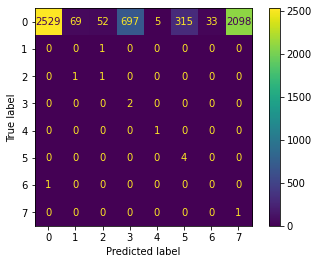

In [ ]:
nb = GaussianNB()
nb_pred_arr = predict(nb)
nb_pred = nb_pred_arr[-1]
print(f'Accuracy: {mean(nb_pred_arr[0])}')
print(f'Precision: {mean(nb_pred_arr[1])}')
print(f'Recall: {mean(nb_pred_arr[2])}')
CMD.from_estimator(nb, test_X, test_Y)

#### XGBoost Classifier

Accuracy: 0.9194492254733219
Precision: 0.9972658594235206
Recall: 0.9194492254733219


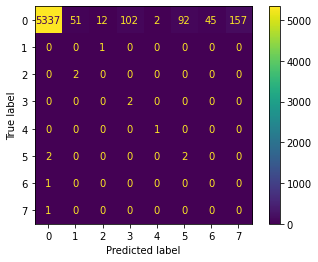

In [ ]:
xgb = XGBClassifier(n_estimators=10)
xgb_pred_arr = predict(xgb)
xgb_pred = xgb_pred_arr[-1]
print(f'Accuracy: {mean(xgb_pred_arr[0])}')
print(f'Precision: {mean(xgb_pred_arr[1])}')
print(f'Recall: {mean(xgb_pred_arr[2])}')
CMD.from_estimator(xgb, test_X, test_Y)

#### AUC-ROC curve

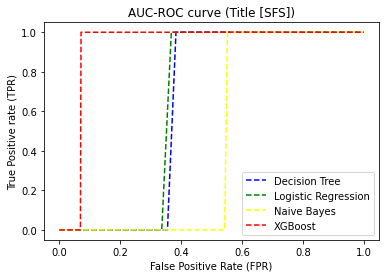

In [ ]:
# roc curve for models
fpr = {}
tpr = {}
thresh ={}
    
fpr1, tpr1, thresh1 = roc_curve(test_Y, dt_pred, pos_label=1)
fpr2, tpr2, thresh2 = roc_curve(test_Y, lr_pred, pos_label=1)
fpr3, tpr3, thresh3 = roc_curve(test_Y, nb_pred, pos_label=1)
fpr4, tpr4, thresh4 = roc_curve(test_Y, xgb_pred, pos_label=1)
# roc curve for tpr = fpr 
random_probs = [0 for i in range(len(test_Y))]
p_fpr, p_tpr, _ = roc_curve(test_Y, random_probs, pos_label=1)

# plot roc curves
plt.plot(fpr1, tpr1, linestyle='--', color='blue', label='Decision Tree')
plt.plot(fpr2, tpr2, linestyle='--',color='green', label='Logistic Regression')
plt.plot(fpr3, tpr3, linestyle='--',color='yellow', label='Naive Bayes')
plt.plot(fpr4, tpr4, linestyle='--',color='red', label='XGBoost')

# title
plt.title('AUC-ROC curve (Title [SFS])')
# x label
plt.xlabel('False Positive Rate (FPR)')
# y label
plt.ylabel('True Positive rate (TPR)')

plt.legend(loc='best')
plt.show();